In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gc

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Machine Learning Final Project/data/malicious_urls.csv')
df['type'].value_counts()
mal_type = {'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3}
df['label'] = [mal_type[item] for item in df['type']]
df

,url,type,label
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,2
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2


In [ ]:
#Character Embeddings
import math
import string
from keras.preprocessing.text import Tokenizer
max_length = df.url.map(len).max()
df['url'] = df['url'].str.lower()
converter = Tokenizer(num_words=None, char_level=True, oov_token='extra')
letter_dict = dict(zip(string.ascii_lowercase+string.punctuation, [i for i in range(58)]))
converter.word_index = letter_dict.copy()
converter.word_index[converter.oov_token] = max(letter_dict.values()) + 1
labels = df['label']
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(df['type'])
test = encoder.transform(df['type'])
hot = np_utils.to_categorical(test)
X_train, X_test, y_train, y_test = train_test_split(df['url'].tolist(), hot, test_size=0.33, random_state=42)
sequences = converter.texts_to_sequences(df['url'])
X_train = np.array( converter.texts_to_sequences(X_train) )
X_test  = np.array( converter.texts_to_sequences(X_test))
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
max_features = 59
embedding_dim = 64
sequence_length = max_length
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(59 +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    
model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2175, 64)          3840      
                                                                 
 conv1d_1 (Conv1D)           (None, 2173, 128)         24704     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 29,060
Trainable params: 29,060
Non-trainable params: 0
__________________________________________________

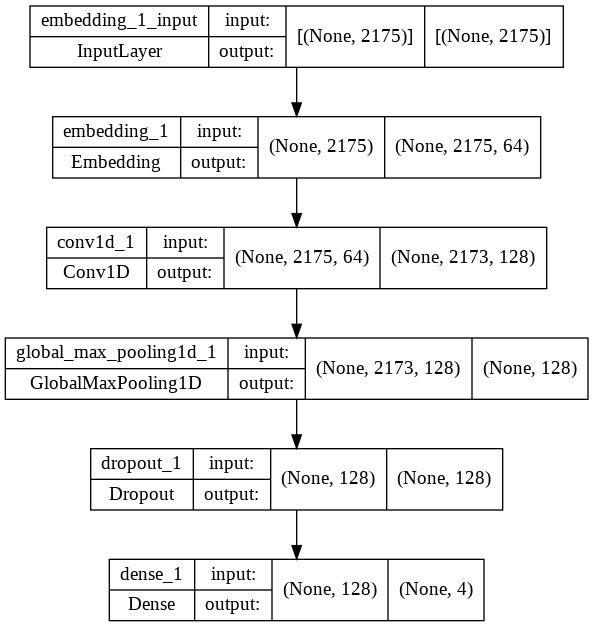

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, validation_split = 0.33, epochs = 4, batch_size = 1024)

Epoch 1/4
286/286 [==============================] - 213s 741ms/step - loss: 0.6253 - accuracy: 0.7941 - val_loss: 0.3869 - val_accuracy: 0.8927
Epoch 2/4
286/286 [==============================] - 211s 737ms/step - loss: 0.4197 - accuracy: 0.8803 - val_loss: 0.3382 - val_accuracy: 0.9181
Epoch 3/4
286/286 [==============================] - 211s 737ms/step - loss: 0.3913 - accuracy: 0.8937 - val_loss: 0.3231 - val_accuracy: 0.9231
Epoch 4/4
286/286 [==============================] - 211s 737ms/step - loss: 0.3809 - accuracy: 0.8989 - val_loss: 0.3143 - val_accuracy: 0.9289


In [ ]:
from sklearn.metrics import confusion_matrix
label_predict = model.predict(X_test)
rounded = (label_predict  > 0.5).astype(int)
scores = model.evaluate(X_test,y_test)

6716/6716 [==============================] - 67s 10ms/step - loss: 0.3174 - accuracy: 0.9265


In [ ]:
print(classification_report(y_test, rounded, target_names=['Benign', 'Defacement', 'Phishing', 'Malware']))

              precision    recall  f1-score   support

      Benign       0.85      1.00      0.92    141516
  Defacement       0.88      0.96      0.92     31608
    Phishing       0.84      0.75      0.79     10694
     Malware       0.25      0.95      0.40     31076

   micro avg       0.64      0.97      0.77    214894
   macro avg       0.71      0.92      0.76    214894
weighted avg       0.77      0.97      0.84    214894
 samples avg       0.71      0.97      0.80    214894



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


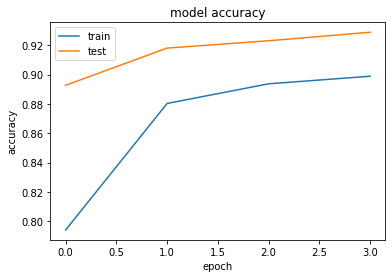

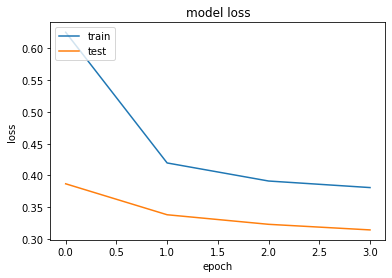

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()